In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt

In [2]:
import strategy.trendlabeling as tlb

In [3]:
import getdata as gd
import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  
import features.marketindicators as mkt
import afml.features.fracdiff as fdiff
from afml.ensemble.sb_bagging import SequentiallyBootstrappedBaggingClassifier
from afml.sample_weights.attribution import get_weights_by_return, get_weights_by_time_decay
from afml.feature_importance.importance import mean_decrease_impurity, mean_decrease_accuracy, single_feature_importance, plot_feature_importance
from afml.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score

from sklearn.utils import resample
from sklearn.utils import shuffle

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

## Import Dataset

In [6]:
df_yf = gd.get_yf_data(tickers= "SPY COMP ALGM", 
                    period='60d', #'1y',   
                    interval='5m' #'1d'
)

[*********************100%***********************]  3 of 3 completed


In [7]:
df = df_yf[df_yf['Ticker'] == 'ALGM']
index_SPY = df_yf[df_yf['Ticker'] == 'SPY']
index_COMP = df_yf[df_yf['Ticker'] == 'COMP']

## Get Labels: Trend Scanning method

In [8]:
# convert Adj Close to numpy
time_series = df['Adj Close'].to_numpy()
window_size_max= 7

# get trend scanning labels
label_output = tlb.get_trend_scanning_labels(time_series=time_series, 
                                             window_size_max=window_size_max, 
                                             threshold=0.0,
                                             opp_sign_ct=3,
                                             side='up')

# drop last rolling window size -1 rows
n = window_size_max-1
#df.drop(df.tail(n).index, inplace = True)
df = df.iloc[:-n]

# append the slope and labels to the df
df['slope'] = label_output['slope']
df['label'] = label_output['label']
# df['isEvent'] = label_output['isEvent']
# isEvent = df[df['isEvent']==1].index

## Get Labels: Simple moving average cross over strategy

In [9]:
# need to cite here ...

# compute moving averages
fast_window = 20
slow_window = 50

df['fast_mavg'] = df['Adj Close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = df['Adj Close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df.head()

# Compute sides
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

## Raw Data 

In [10]:
# Save the raw data
raw_data = df.drop(columns='Close').copy()

# Drop the NaN values from our data set
df.dropna(axis=0, how='any', inplace=True)

In [11]:
print(df['label'].value_counts())
print(df['side'].value_counts())

 1    2393
-1    2231
Name: label, dtype: int64
 1.0    2587
-1.0    2037
Name: side, dtype: int64


## Form Dollar Bars

In [12]:
# construct the input data
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
# frequency = _df.Volume.mean()*20
frequency = df['Volume'].resample('D').sum().mean()/10.0

# generate the dollar bars
dollar_bars = bars.generate_dollarbars(trades, frequency=frequency) 

# define closing price
close = dollar_bars.close.copy()

## Filter Events using CUSUM Filter

We will then predict what will happen if the event is triggered, based on the 'side' signal from the Trend Following Strategy 

In [13]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

# apply cusum filter to identify events as cumulative log return passed threshold
#tEvents = flt.getTEvents(close, h=dailyVolatility.mean()*0.5)
tEvents = flt.cusum_filter(close, threshold=dailyVolatility.mean()*0.5)

# Define vertical barrier - subjective judgment
num_days = 1

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)

In [14]:
# get side labels from trend following method
side_labels = []

for dt in dollar_bars.index:
    side_labels.append(df.loc[dt]['label'])

side_labels = pd.Series(side_labels, index=dollar_bars.index)

## Create Trade or Not Trade labels using Triple Barrier Method

In [15]:
# Define upper and lower horizontal barriers
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(dollar_bars.close, 
                         t_events=tEvents, 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=side_labels).dropna()



In [16]:
labels = tbar.get_bins(triple_barrier_events = events, close=close)

print(labels.bin.value_counts())

0    329
1     70
Name: bin, dtype: int64


In [17]:
# Drop underpopulated labels
clean_labels  = tbar.drop_labels(labels)

print(clean_labels.bin.value_counts())

0    329
1     70
Name: bin, dtype: int64


In [18]:
clean_labels[clean_labels['bin']==1]

,ret,trgt,bin,side
2022-12-23 09:35:00,0.023358,0.010898,1,1.0
2023-01-03 09:30:00,0.025081,0.010694,1,-1.0
2023-01-03 09:45:00,0.022549,0.010935,1,-1.0
2023-01-04 14:55:00,0.021328,0.010265,1,-1.0
2023-01-05 10:25:00,0.022360,0.010732,1,-1.0
...,...,...,...,...
2023-03-14 15:55:00,0.026603,0.012056,1,-1.0
2023-03-15 09:40:00,0.028195,0.013030,1,-1.0
2023-03-15 13:40:00,0.046626,0.022746,1,1.0
2023-03-16 09:40:00,0.031625,0.014879,1,1.0


## Results of Primary Model without features

In [22]:
primary_forecast = pd.DataFrame(clean_labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       329
           1       0.18      1.00      0.30        70

    accuracy                           0.18       399
   macro avg       0.09      0.50      0.15       399
weighted avg       0.03      0.18      0.05       399

Confusion Matrix
[[  0 329]
 [  0  70]]

Accuracy
0.17543859649122806


#### Fitting a Meta model

Use features: volatility, serial correlation, relative strength to S&P

In [23]:
# Save the raw data
raw_data = df.drop(columns='Close').copy()

raw_data.head()

,Ticker,Adj Close,High,Low,Open,Volume,slope,label,fast_mavg,slow_mavg,side
Date,,,,,,,,,,,
2022-12-20 13:40:00,ALGM,30.045000,30.115000,30.045000,30.110001,6801.0,-0.0375,-1,29.953695,29.78871,1.0
2022-12-20 13:45:00,ALGM,30.040001,30.090000,30.014999,30.049999,5114.0,-0.0180,-1,29.960945,29.79951,1.0
2022-12-20 13:50:00,ALGM,29.969999,30.059999,29.969999,30.049999,17844.0,0.0100,1,29.964445,29.81171,1.0
2022-12-20 13:55:00,ALGM,29.940001,29.975000,29.879999,29.969999,16614.0,0.0300,1,29.966445,29.82151,1.0
2022-12-20 14:00:00,ALGM,29.990000,30.000000,29.920000,29.940001,6640.0,0.0090,1,29.973195,29.83071,1.0


#### Features

In [26]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['Adj Close']).diff()

# Momentum
raw_data['mom1'] = raw_data['Adj Close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['Adj Close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['Adj Close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['Adj Close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['Adj Close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=2, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=2, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=2, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=2, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=2, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=2, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=2, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=2, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [ ]:
# # Re compute sides
# raw_data['side'] = np.nan

# long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
# short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

# raw_data.loc[long_signals, 'side'] = 1
# raw_data.loc[short_signals, 'side'] = -1

In [27]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

In [28]:
raw_data.columns

Index(['Ticker', 'Adj Close', 'High', 'Low', 'Open', 'Volume', 'slope',
       'label', 'fast_mavg', 'slow_mavg', 'side', 'log_ret', 'mom1', 'mom2',
       'mom3', 'mom4', 'mom5', 'volatility_50', 'volatility_31',
       'volatility_15', 'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4',
       'autocorr_5', 'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5'],
      dtype='object')

In [29]:
# serial correlation
srl_corr = mkt.df_rolling_autocorr(mkt.returns(close), window=7).rename('srl_corr')

# relative strength to SPY
rs_SPY = mkt.get_relative_strength(df['Adj Close'], index_SPY['Adj Close']).shift(1).dropna()


In [30]:
# fractional differentiated log dollar bar prices

# cumulative sum of stock log-prices
ticker_log_cumsum = np.log(dollar_bars.close).cumsum()

# frac diff 1 time
dfx1 = fdiff.frac_diff_ffd(ticker_log_cumsum.to_frame(), diff_amt=1).dropna()

# apply cumsum filter
dfx1_close = dfx1.close.copy()
df_tEvents = flt.getTEvents(dfx1_close, h=dfx1.std().iat[0]*2)

# fracDiff value feature
frac_diff_feat = dfx1.loc[df_tEvents] 


In [31]:
features = (pd.DataFrame()
            .assign(vol=events.trgt)
            #.assign(side=clean_labels.side)
            #.assign(srl_corr=srl_corr)
            .assign(rs_SPY=rs_SPY)
            #.assign(frac_diff_feat=frac_diff_feat)
            .drop_duplicates()
            .dropna())

In [32]:
# Get features at event dates
_X = raw_data.loc[clean_labels.index, :]

In [33]:
# Drop unwanted columns
_X.drop(['Ticker',
        'Adj Close', 'High', 'Low', 'Open', 'Volume', 
        #'fast_mavg', 'slow_mavg', 'side', # remove for MA crossover
        #'slope', 'label', # remove for trend scanning
        ], axis=1, inplace=True)

In [34]:
Xy = _X.join(features).join(clean_labels['bin']).dropna()

In [35]:
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]

In [36]:
y.value_counts()

0    329
1     70
Name: bin, dtype: int64

In [60]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, shuffle=False)

In [61]:
Xy.columns

Index(['slope', 'label', 'fast_mavg', 'slow_mavg', 'side', 'log_ret', 'mom1',
       'mom2', 'mom3', 'mom4', 'mom5', 'volatility_50', 'volatility_31',
       'volatility_15', 'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4',
       'autocorr_5', 'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'vol',
       'rs_SPY', 'bin'],
      dtype='object')

## Sample Weights

In [62]:
return_based_sample_weights = get_weights_by_return(events.loc[X_train.index], df.loc[X_train.index, 'Adj Close'])
time_based_sample_weights = get_weights_by_time_decay(events.loc[X_train.index], df.loc[X_train.index, 'Adj Close'], decay=0.5)

2023-03-20 15:43:40.482677 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-20 15:43:41.551755 100.0% _apply_weight_by_return done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-20 15:43:42.744489 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-20 15:43:43.821173 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


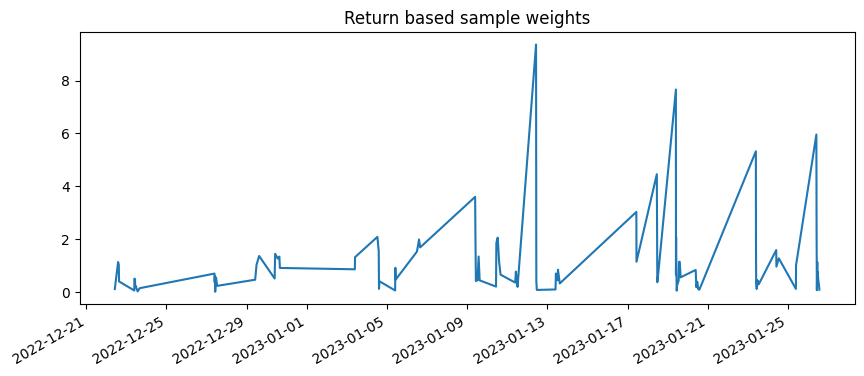

In [63]:
plt.figure(figsize=(10,4))
plt.title('Return based sample weights')
return_based_sample_weights.plot()
plt.show()

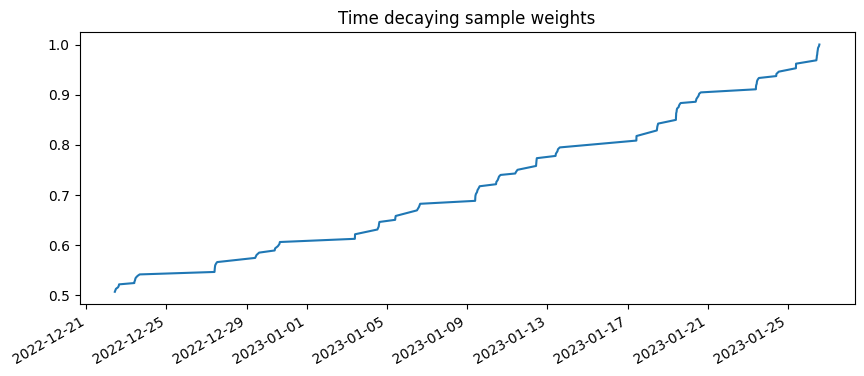

In [64]:
plt.figure(figsize=(10,4))
plt.title('Time decaying sample weights')
time_based_sample_weights.plot()
plt.show()

## Cross-Validation 

In [104]:
from sklearn.svm import SVC

In [105]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[10, 25, 50, 100, 256, 512],
              'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001], 
              }

In [106]:
cv_gen_standard = KFold(4)
cv_gen_purged = PurgedKFold(n_splits=4, samples_info_sets=events.loc[X_train.index].t1)

In [115]:
def perform_grid_search(X_data, y_data, cv_gen, scoring, parameters, type='standard', sample_weight=None):
    """
    Grid search using Purged CV without using sample weights in fit(). Returns top model and top score
    """
    max_cross_val_score = -np.inf
    top_model = None

    if type=='SVC' or type=='seq_boot_SVC':
        for C in parameters['C']:
            for gamma in parameters['gamma']:
                clf_SVC = SVC(C=C,
                                gamma=gamma,
                                class_weight='balanced',
                                kernel='linear',
                                random_state=RANDOM_STATE
                )

                if type =='SVC':
                    clf = clf_SVC
                elif type == 'seq_boot_SVC':
                    clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, ## events
                                                                price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], ## df
                                                                estimator=clf_SVC, 
                                                                random_state=42, n_jobs=-1, oob_score=False,
                                                                max_features=1.)
                temp_score_base = ml_cross_val_score(clf, X_data, y_data, cv_gen, scoring=scoring, sample_weight=sample_weight)
                if temp_score_base.mean() > max_cross_val_score:
                    max_cross_val_score = temp_score_base.mean()
                    print(temp_score_base.mean())
                    top_model = clf

    else:    
        for m_depth in parameters['max_depth']:
            for n_est in parameters['n_estimators']:
                clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                                max_depth=m_depth, class_weight='balanced')

                if type == 'standard':
                    clf = BaggingClassifier(n_estimators=n_est, 
                                            estimator=clf_base, 
                                            random_state=42, n_jobs=-1, 
                                            oob_score=False, max_features=1.)
                elif type == 'random_forest':
                    clf = RandomForestClassifier(n_estimators=n_est, 
                                                max_depth=m_depth, 
                                                random_state=42, 
                                                n_jobs=-1, 
                                                oob_score=False, 
                                                criterion='entropy',
                                                class_weight='balanced_subsample', 
                                                max_features=1.)
                elif type == 'sequential_bootstrapping':
                    clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, ## events
                                                                    price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], ## df
                                                                    n_estimators=n_est, estimator=clf_base, 
                                                                    random_state=42, n_jobs=-1, oob_score=False,
                                                                    max_features=1.)
                temp_score_base = ml_cross_val_score(clf, X_data, y_data, cv_gen, scoring=scoring, sample_weight=sample_weight)
                if temp_score_base.mean() > max_cross_val_score:
                    max_cross_val_score = temp_score_base.mean()
                    print(temp_score_base.mean())
                    top_model = clf
    return top_model, max_cross_val_score

In [50]:
warnings.filterwarnings('ignore')

In [93]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, type = 'standard')
print(top_model, cross_val_score)

0.05555555555555556
BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   criterion='entropy',
                                                   max_depth=2,
                                                   random_state=42),
                  n_jobs=-1, random_state=42) 0.05555555555555556


In [94]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, type = 'standard', 
                                                 sample_weight=return_based_sample_weights.values)
print(top_model, cross_val_score)

0.03837084930279906
0.06126753418249009
0.12335091841497187
BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   criterion='entropy',
                                                   max_depth=2,
                                                   random_state=42),
                  n_estimators=256, n_jobs=-1, random_state=42) 0.12335091841497187


In [47]:
top_model, cross_val_score = perform_grid_search_sample_weights(X_train, y_train, cv_gen_purged, 'f1', type = 'standard')
print(top_model, cross_val_score)

0.10311673869127287
BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   criterion='entropy',
                                                   max_depth=2,
                                                   random_state=42),
                  n_jobs=-1, random_state=42) 0.10311673869127287


In [48]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', type = 'random_forest')
print(top_model, cross_val_score)

0.1277777777777778
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, max_features=1.0, n_estimators=10,
                       n_jobs=-1, random_state=42) 0.1277777777777778


In [49]:
top_model, cross_val_score = perform_grid_search_sample_weights(X_train, y_train, cv_gen_purged, 'f1', type = 'random_forest')
print(top_model, cross_val_score)

0.039105758061931964
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, max_features=1.0, n_estimators=10,
                       n_jobs=-1, random_state=42) 0.039105758061931964


In [116]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, 
                                                 type = 'SVC',
                                                 sample_weight=return_based_sample_weights.values
                                                 )
print(top_model, cross_val_score)

0.15604736801037314
SVC(C=1, class_weight='balanced', gamma=1, kernel='linear', random_state=42) 0.15604736801037314


In [117]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, 
                                                 type = 'seq_boot_SVC',
                                                 sample_weight=return_based_sample_weights.values
                                                 )
print(top_model, cross_val_score)

0.015535941738574406
0.17035214627909595
SequentiallyBootstrappedBaggingClassifier(estimator=SVC(C=10,
                                                        class_weight='balanced',
                                                        gamma=1,
                                                        kernel='linear',
                                                        random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2022-12-22 10:10:00    29.522100
2022-12-22 10:15:00    29.590000
2022-12-22 10:20:00    29.559999
2022-12-22 10:25:00    29.570000
2022-12-22 10:30:00    29.570000
                         ...    
2023-01-26 13:15:00    34.899101
2023-01-26 13:20:00    34.919899
2023-01...
2022-12-22 11:30:00   2022-12-22 15:15:00
2022-12-22 14:05:00   2022-12-23 14:05:00
2022-12-22 14:55:00   2022-12-23 15:00:00
2022-12-22 15:15:00   2022-12-23 15:15:00
                              ...        
2023-01-

In [ ]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, 
                                                 type = 'SVC',
                                                 #sample_weight=return_based_sample_weights.values
                                                 )
print(top_model, cross_val_score)

In [ ]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, 
                                                 type = 'seq_boot_SVC',
                                                 #sample_weight=return_based_sample_weights.values
                                                 )
print(top_model, cross_val_score)

In [51]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', 
                                                 type = 'sequential_bootstrapping')
print(top_model, cross_val_score)

0.057189542483660136
0.0839160839160839
SequentiallyBootstrappedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                           criterion='entropy',
                                                                           max_depth=4,
                                                                           random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2022-12-22 10:10:00    29.522100
2022-12-22 10:15:00    29.590000
2022-12-22 10:20:00    29.559999
2022-12-22 10:25:00    29.570000
2022-12-22 10:30:00    29.570000
                         ...    
2023-02-03 09:30:00    40.650002
2023-02-03 09...
2022-12-22 11:30:00   2022-12-22 15:15:00
2022-12-22 14:05:00   2022-12-23 14:05:00
2022-12-22 14:55:00   2022-12-23 15:00:00
2022-12-22 15:15:00   2022-12-23 15:15:00
                              ...        
2023-02-02 15:

In [52]:
top_model, cross_val_score = perform_grid_search_sample_weights(X_train, y_train, cv_gen_purged, 'f1', type = 'sequential_bootstrapping')
print(top_model, cross_val_score)

0.1055865685885087
SequentiallyBootstrappedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                           criterion='entropy',
                                                                           max_depth=2,
                                                                           random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2022-12-22 10:10:00    29.522100
2022-12-22 10:15:00    29.590000
2022-12-22 10:20:00    29.559999
2022-12-22 10:25:00    29.570000
2022-12-22 10:30:00    29.570000
                         ...    
2023-02-03 09:30:00    40.650002
2023-02-03 09...
2022-12-22 11:30:00   2022-12-22 15:15:00
2022-12-22 14:05:00   2022-12-23 14:05:00
2022-12-22 14:55:00   2022-12-23 15:00:00
2022-12-22 15:15:00   2022-12-23 15:15:00
                              ...        
2023-02-02 15:25:00   2023-02-03 10

In [119]:
top_model.coef_


AttributeError: 'SequentiallyBootstrappedBaggingClassifier' object has no attribute 'coef_'

## Feature Importance

The SVC classifier does not provide a direct wat to obtain feature importances. However, we can use the coefficients of the hyperplane that seperates the classes to estimate the importance of each feature. The magnitude of the coefficient corresponds to the importance of the corresponding feature in the classification.

In [76]:
# MDI, MDA, SFI feature importance
mdi_feat_imp = mean_decrease_impurity(top_model, X_train.columns)
mda_feat_imp = mean_decrease_accuracy(top_model, X_train, y_train, cv_gen_purged, scoring='f1', 
                                                         sample_weight=return_based_sample_weights.values)
sfi_feat_imp = single_feature_importance(top_model, X_train, y_train, cv_gen_purged, scoring='f1',
                                     sample_weight=return_based_sample_weights.values)

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [ ]:
plot_feature_importance(mdi_feat_imp, 0, 0)

In [ ]:
plot_feature_importance(mda_feat_imp, 0, 0)

In [ ]:
plot_feature_importance(sfi_feat_imp, 0, 0)

## Fitting Top Model

In [ ]:
y_pred_rf = top_model.predict_proba(X_test)[:, 1]
y_pred = top_model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, 
                            n_estimators=n_estimator,
                            criterion='entropy', 
                            class_weight='balanced',
                            random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
top_model

## Backtest

In [ ]:
y_pred